# Import Library

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from collections import Counter
from sklearn.preprocessing import OneHotEncoder

# Preprocessing Data, clear data

In [6]:
df = pd.read_csv('StudentDepressionDataset.csv')

In [8]:
# Clean data (id, gender[male -> 0, femail -> 1])
df = df.drop(['id'], axis = 1)

df.loc[df['Gender'] == 'Male', 'Gender'] = 0
df.loc[df['Gender'] == 'Female', 'Gender'] = 1

removes_unqualify_cities = df['City'].value_counts()[df['City'].value_counts() < 100]
#Take the cities name as an index stored in r_u_c
# ~ (tilde) negates the condition, keeping only rows where the city is NOT in the list of cities to remove
df = df[~df['City'].isin(removes_unqualify_cities.index)]

df = df.loc[df['Profession']=='Student'] #Boolean filtering which return True as Student

#Drop the profession (1 value only) and Work Pressure (Student has no work pressure/low count)
df = df.drop(['Profession', 'Work Pressure', 'Job Satisfaction'], axis = 1)

# Remove student has age > 30 (low count)
df = df.loc[df['Age'] <= 30]

df = df.loc[df['Academic Pressure'] > 0.0]

df = df.loc[df['Study Satisfaction'] > 0.0]

## CHECKING THE SLEEP DURATION AND REMOVING 'OTHERS' DUW LOW COUNTS
df = df.loc[df['Sleep Duration'] != 'Others']

## CHANGING SLEEP DURATION TO NUMERICAL
df.loc[df['Sleep Duration'] == 'Less than 5 hours', 'Sleep Duration'] = 0
df.loc[df['Sleep Duration'] == '5-6 hours', 'Sleep Duration'] = 1
df.loc[df['Sleep Duration'] == '7-8 hours', 'Sleep Duration'] = 2
df.loc[df['Sleep Duration'] == 'More than 8 hours', 'Sleep Duration'] = 3

## CHECKING DIEATARY HABITS AND REMOVING 'OTHERS' DUE LOW COUNTS
df = df.loc[df['Dietary Habits'] != 'Others']

## CHANGING DIETARY HABITS TO NUMERICAL
df.loc[df['Dietary Habits'] == 'Healthy', 'Dietary Habits'] = 0
df.loc[df['Dietary Habits'] == 'Moderate', 'Dietary Habits'] = 1
df.loc[df['Dietary Habits'] == 'Unhealthy', 'Dietary Habits'] = 2

## CREATING NEW DEGREE COLUMN WITH ONLY GRADUATED, POST GRADUATED AND HIGHER SECONDARY
df['New_Degree'] = 'Unknown'  # Default value for unmatched degrees
df.loc[df['Degree'].str.contains(r'BSc|BCA|B.Ed|BHM|B.Pharm|B.Com|BE|BA|B.Arch|B.Tech|BBA|LLB', regex=True, na=False), 'New_Degree'] = 'Graduated'
df.loc[df['Degree'].str.contains(r'MSc|MCA|M.Ed|M.Pharm|M.Com|ME|MA|M.Arch|M.Tech|MBA|LLM', regex=True, na=False), 'New_Degree'] = 'Post Graduated'
df.loc[df['Degree'] == 'Class 12', 'New_Degree'] = 'Higher Secondary'
# Remove 'Unknown' if you want to exclude those rows:
df = df[df["New_Degree"] != "Unknown"]

## CHANGING NEW DEGREE TO NUMERICAL
# Convert to numerical values
df['New_Degree'] = df['New_Degree'].map({'Graduated': 0, 'Post Graduated': 1, 'Higher Secondary': 2})

## CHANGING SUICIDAL THOUGHTS TO NUMERICAL
df.loc[df['Have you ever had suicidal thoughts ?'] == 'Yes', 'Have you ever had suicidal thoughts ?'] = 1
df.loc[df['Have you ever had suicidal thoughts ?'] == 'No', 'Have you ever had suicidal thoughts ?'] = 0

## CHANGING FAMILY HISTORY OF MENTAL ILLNESS TO NUMERICAL
df.loc[df['Family History of Mental Illness'] == 'Yes', 'Family History of Mental Illness'] = 1
df.loc[df['Family History of Mental Illness'] == 'No', 'Family History of Mental Illness'] = 0

# ## CREATING DUMMY VARIABLES FOR THE CITY COLUMN
# encoder = OneHotEncoder(sparse_output=False) #Text to num (False to make the result is the normal table (not compress all of them together))
# encoded = encoder.fit_transform(df[['City']])
# encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['City']))
# ## ADJUSTING THE INDEX
# encoded_df.index = df.index
# df = pd.concat([df, encoded_df], axis=1)
## REMOVING THE ORIGINAL CITY AND OLD DEGREE COLUMN
df = df.drop(['City', 'Degree'], axis=1)
## Change types of some object -> int
df[["Gender", "Sleep Duration", "Dietary Habits", "Have you ever had suicidal thoughts ?", "New_Degree", "Family History of Mental Illness"]] = df[["Gender", "Sleep Duration", "Dietary Habits", "Have you ever had suicidal thoughts ?", "New_Degree", "Family History of Mental Illness"]].astype(int)

## CHECKING FOR NULL VALUES AND REMOVING
df.isnull().sum()
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20490 entries, 1 to 27900
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 20490 non-null  int32  
 1   Age                                    20490 non-null  float64
 2   Academic Pressure                      20490 non-null  float64
 3   CGPA                                   20490 non-null  float64
 4   Study Satisfaction                     20490 non-null  float64
 5   Sleep Duration                         20490 non-null  int32  
 6   Dietary Habits                         20490 non-null  int32  
 7   Have you ever had suicidal thoughts ?  20490 non-null  int32  
 8   Work/Study Hours                       20490 non-null  float64
 9   Financial Stress                       20490 non-null  float64
 10  Family History of Mental Illness       20490 non-null  int32  
 11  Depress

# Choosing independent variable and dependent variable

In [11]:
X = df.drop(columns="Depression")
y = df["Depression"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Feature scaling is the process of transforming your input variables into the similar range because these differences can cause problems for some machine learning models rely on distance like KNN and Logistic Regression

# Using Library

In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [19]:
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
dt = DecisionTreeClassifier(random_state=42)

In [21]:
ensemble = VotingClassifier(estimators=[
    ('knn', knn),
    ('lr', log_reg),
    ('dt', dt)
], voting='hard')

In [23]:
ensemble.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier(random_state=42))])

In [25]:
y_pred = ensemble.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report: \n", classification_report(y_test, y_pred))

Accuracy: 0.8397423384735506

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.73      0.77      1840
           1       0.86      0.90      0.88      3283

    accuracy                           0.84      5123
   macro avg       0.83      0.82      0.82      5123
weighted avg       0.84      0.84      0.84      5123



# Code form scratch

## Decision Tree

In [29]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
        self.feature_importances_ = None

    def gini_impurity(self, y):
        """Compute Gini Impurity"""
        m = len(y) #Num of Samples
        if m == 0:
            return 0
        p1 = np.sum(y == 1) / m  # Probability of class 1
        p0 = 1 - p1  # Probability of class 0
        return 1 - (p0**2 + p1**2)

    def best_split(self, X, y):
        """Find the best split based on Gini Impurity"""
        best_feature, best_threshold, best_gain = None, None, -1
        m, n = X.shape # m = number of samples, n = number of features
        parent_gini = self.gini_impurity(y)

        for feature in range(n):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                gini_left = self.gini_impurity(y[left_mask])
                gini_right = self.gini_impurity(y[right_mask])
                gini_split = (np.sum(left_mask) / m) * gini_left + (np.sum(right_mask) / m) * gini_right
                gini_gain = parent_gini - gini_split
                if gini_gain > best_gain:
                    best_gain = gini_gain
                    best_feature = feature
                    best_threshold = threshold
                    self.feature_importance_scores[feature] += gini_gain
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        if len(np.unique(y)) == 1 or (self.max_depth and depth >= self.max_depth):
            return np.bincount(y).argmax()
        feature, threshold = self.best_split(X, y)
        if feature is None:
            return np.bincount(y).argmax()

        left_mask = X[:, feature] <= threshold 
        right_mask = ~left_mask 
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self.build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self.build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        """Train the decision tree"""
        
        self.feature_importance_scores = np.zeros(X.shape[1])  # add this
        self.tree = self.build_tree(X, y)
        total = np.sum(self.feature_importance_scores)
        if total > 0:
            self.feature_importances_ = self.feature_importance_scores / total
        else:
            self.feature_importances_ = np.zeros_like(self.feature_importance_scores)


    def predict_sample(self, sample, tree):
        """Make a prediction for one sample"""
        if isinstance(tree, dict):
            if sample[tree['feature']] <= tree['threshold']:
                return self.predict_sample(sample, tree['left'])
            else:
                return self.predict_sample(sample, tree['right'])
        return tree

    def predict(self, X):
        """Make predictions for a dataset"""
        return np.array([self.predict_sample(sample, self.tree) for sample in X])
    def get_feature_importance(self):
        return self.feature_importances_

## Logistic Regression

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegression:
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_pred]
    def get_feature_importance(self):
        return np.abs(self.weights) 

## KNN

In [35]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest).most_common(1)
        return most_common[0][0]

## Ensemble Model

In [38]:
class EnsembleClassifier:
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        majority_votes = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
        return majority_votes
        
    def get_feature_importance(self):
        importances = []
        for model in self.models:
            if hasattr(model, 'get_feature_importance'):
                imp = model.get_feature_importance()
                imp = imp / np.sum(imp) if np.sum(imp) > 0 else imp
                importances.append(imp)
        return np.mean(importances, axis=0)

In [40]:
dt = DecisionTree()
lr = LogisticRegression()
knn = KNN(k=5)

X_train = np.array(X_train_scaled)
y_train = np.array(y_train)
X_test = np.array(X_test_scaled)
y_test = np.array(y_test)

ensemble_self_build = EnsembleClassifier([dt,lr,knn])
ensemble_self_build.fit(X_train, y_train)
y_pred_1 = ensemble_self_build.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_1))
print("\nClassification Report: \n", classification_report(y_test, y_pred_1))

Accuracy: 0.8387663478430607

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.75      0.77      1840
           1       0.86      0.89      0.88      3283

    accuracy                           0.84      5123
   macro avg       0.83      0.82      0.82      5123
weighted avg       0.84      0.84      0.84      5123



                                  Feature  Coefficient
1                                     Age     0.177267
3                                    CGPA     0.157616
7   Have you ever had suicidal thoughts ?     0.118217
2                       Academic Pressure     0.114973
9                        Financial Stress     0.081939
0                                  Gender     0.080067
8                        Work/Study Hours     0.074064
4                      Study Satisfaction     0.059247
6                          Dietary Habits     0.051298
5                          Sleep Duration     0.040666
11                             New_Degree     0.022609
10       Family History of Mental Illness     0.022036


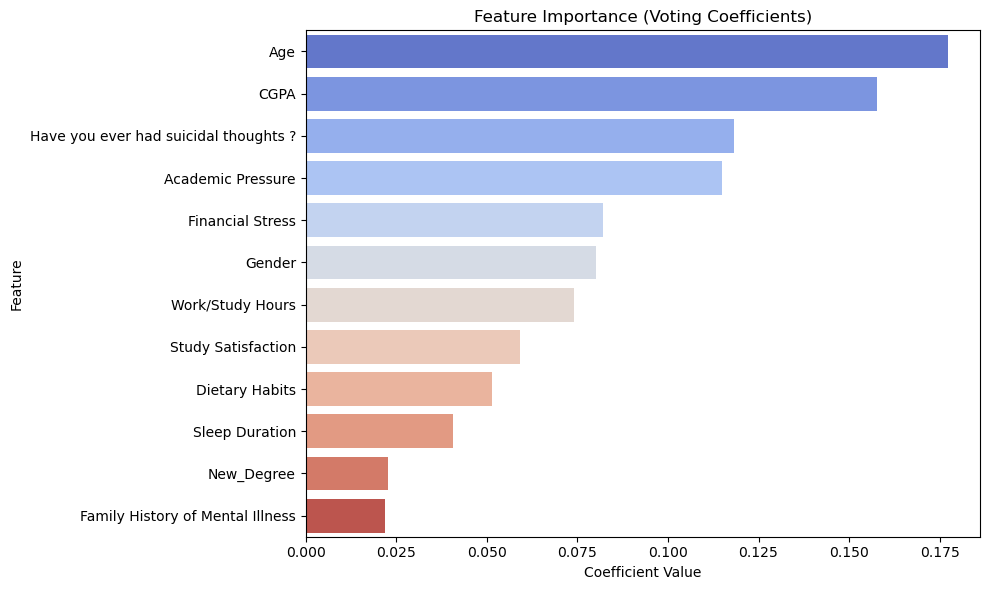

In [42]:
# Get feature names
feature_names = df.drop('Depression', axis=1).columns

# Get feature importances from ensemble
coefficients = ensemble_self_build.get_feature_importance()

# Create DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Show table
print(feature_importance[['Feature', 'Coefficient']])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='coolwarm')
plt.title('Feature Importance (Voting Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

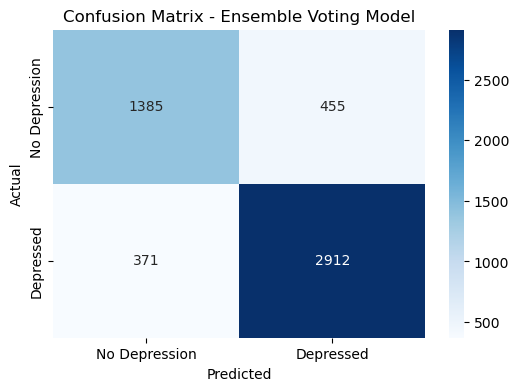

In [44]:
# Make predictions using your voting ensemble
y_pred_ensemble = ensemble_self_build.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_ensemble)

# Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Depression', 'Depressed'],
            yticklabels=['No Depression', 'Depressed'])
plt.title("Confusion Matrix - Ensemble Voting Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()